In [9]:
# 1. For i in front/*; do imagemagick/convert 300x300px ...
# 2. Del all images with 2kb (sort, manual, Windows Explorer)
# 3. Basic Preparation Data with bash
#    cat sentencing.csv | sed -e 's/LIFE/100/g' |awk -F\; '{print $1 " " $7}'| awk 'BEGIN {id="id"; yrs="years"} id != $1 {print id","yrs; id=$1; yrs=$2 } id != "id" {yrs = yrs + $2}' >id_years.csv

# Images and Pre-Trained model files are large
rootdir='C:\\Users\\Sandow\\Documents\\CAS AML Project\\cas-aml-prisioners'

import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

os.environ["PATH"] += os.pathsep + 'C:\\Program Files (x86)\\Graphviz\\bin'
os.environ["PATH"] += os.pathsep + 'C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v10.1\\lib\\x64'
os.environ["CUDA_PATH"] = 'C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v10.1\\'

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.list_physical_devices()

sentence_f='id_years2.csv'
sentence = pd.read_csv(sentence_f)
sentence.head()


Num GPUs Available:  1


,A00147,174
0,A00360,203
1,A00367,83
2,A01054,225
3,A01072,6265
4,A01077,16


In [10]:
sentence.describe()

,174
count,50005.000000
mean,48.071613
std,76.352864
min,0.000000
25%,16.000000
50%,29.000000
75%,55.000000
max,6265.000000


In [16]:
data_augmentation = keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    ]
)

# small version of the Xception network
# https://keras.io/examples/vision/image_classification_from_scratch/
#
def make_model(input_shape, num_classes):
    from tensorflow.keras import layers
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block TODO Augmentation removed due to "invalid image file"
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128,256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

In [17]:
image_size = (300, 300)
batch_size = 16
imgDir=os.path.join(rootdir,'Prisioners')

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    imgDir,
    validation_split=0.3,
    subset="training",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    imgDir,
    validation_split=0.3,
    subset="validation",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)


Found 50026 files belonging to 4 classes.
Using 35019 files for training.
Found 50026 files belonging to 4 classes.
Using 15007 files for validation.


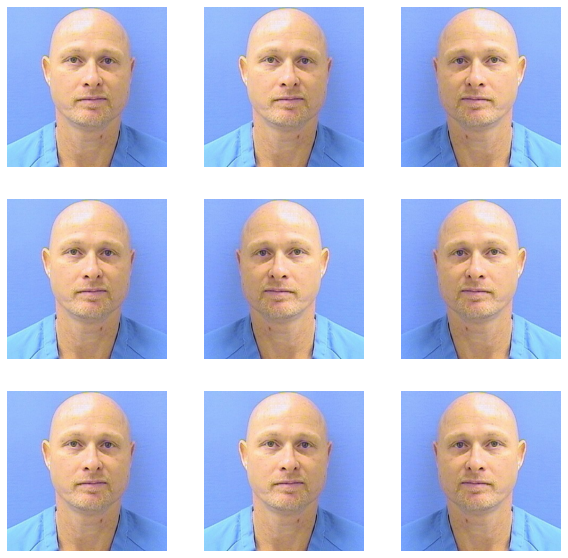

In [13]:
inputs = keras.Input(shape=(300,300,3))
x = data_augmentation(inputs)
x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(x)
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


In [18]:
model = make_model(input_shape=image_size + (3,), num_classes=4)
keras.utils.plot_model(model, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [19]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, validation_data=val_ds,
)


Epoch 1/10
2189/2189 [==============================] - ETA: 0s - loss: 2.2348 - accuracy: 0.2478

InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument:  assertion failed: [Unable to decode bytes as JPEG, PNG, GIF, or BMP]
	 [[{{node decode_image/cond_jpeg/else/_1/decode_image/cond_jpeg/cond_png/else/_20/decode_image/cond_jpeg/cond_png/cond_gif/else/_39/decode_image/cond_jpeg/cond_png/cond_gif/Assert/Assert}}]]
	 [[IteratorGetNext]]
  (1) Invalid argument:  assertion failed: [Unable to decode bytes as JPEG, PNG, GIF, or BMP]
	 [[{{node decode_image/cond_jpeg/else/_1/decode_image/cond_jpeg/cond_png/else/_20/decode_image/cond_jpeg/cond_png/cond_gif/else/_39/decode_image/cond_jpeg/cond_png/cond_gif/Assert/Assert}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_2]]
0 successful operations.
0 derived errors ignored. [Op:__inference_test_function_30093]

Function call stack:
test_function -> test_function
